# Blogs Dataset

In [ ]:
%cd modularity_aware_gae
!python train.py --dataset=blogs --features=False --task=task_2 --model=gcn_vae --iterations=200 --learning_rate=0.01 --hidden=32 --dimension=16 --beta=0.75 --lamb=0.5 --gamma=2 --s_reg=10 --fastgae=False --nb_run=1
%cd ..

c:\Users\Moher\Personal\PhD\Projects\modularity_aware_gae\modularity_aware_gae

 
 
 
[MODULARITY-AWARE GRAPH AUTOENCODERS]
 
 
 

EXPERIMENTAL SETTING 

- Graph dataset: blogs
- Mode name: gcn_vae
- Number of models to train: 1
- Number of training iterations for each model: 200
- Learning rate: 0.01
- Dropout rate: 0.0
- Use of node features in the input layer: False
- Dimension of the GCN hidden layer: 32
- Dimension of the output layer: 16
- lambda: 0.5
- beta: 0.75
- gamma: 2.0
- s: 10
- FastGAE: no 

Final embedding vectors will be evaluated on:
- Task 2, i.e., joint community detection and link prediction

 
 
 

LOADING DATA

Loading the blogs graph
- Number of nodes: 1224
- Number of communities: 2
- Use of node features: False
Done! 
 
 
 

EXPERIMENTS ON MODEL 1 / 1 

STEP 1/3 - PREPROCESSING STEPS 

Masking some edges from the training graph, for link prediction
(validation set: 5.0 % of edges - test set: 10.0 % of edges)
Done! 

Preprocessing node features
Done! 

Running 

2025-02-27 02:12:21.831112: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_100.dll'; dlerror: cudart64_100.dll not found
2025-02-27 02:12:21.831438: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-02-27 02:12:27.257037: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library nvcuda.dll
2025-02-27 02:12:27.316039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce RTX 4080 major: 8 minor: 9 memoryClockRate(GHz): 2.505
pciBusID: 0000:01:00.0
2025-02-27 02:12:27.317041: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_100.dll'; dlerror: cudart64_100.dll not found
2025-02-27 02:12:27.317822: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cubl

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from collections import defaultdict
from datetime import datetime
import re

def parse_and_visualize_laundering_patterns(file_path, num_patterns=4):
    """
    Parse the IBM AML patterns file and visualize random laundering attempts
    
    Args:
        file_path: Path to the HI-Small_Patterns.txt file
        num_patterns: Number of random patterns to visualize
    """
    # Read the file
    with open(file_path, 'r') as f:
        content = f.read()
    
    # Extract all patterns using regex
    pattern_blocks = re.findall(r'(BEGIN LAUNDERING ATTEMPT - [^:]*:?[^\n]*\n(.*?)\nEND LAUNDERING ATTEMPT - [^\n]*)', 
                                content, re.DOTALL)
    
    # Select random patterns
    selected_patterns = random.sample(pattern_blocks, min(num_patterns, len(pattern_blocks)))
    
    # Set up visualization
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    # Process each selected pattern
    for i, (header, transactions_text) in enumerate(selected_patterns):
        # Extract pattern type
        pattern_type = re.search(r'BEGIN LAUNDERING ATTEMPT - ([^:]*)', header).group(1)
        
        # Process transactions
        transactions = []
        for line in transactions_text.strip().split('\n'):
            if line.strip():
                transactions.append(line.split(','))
        
        # Create a directed graph
        G = nx.DiGraph()
        
        # Add nodes and edges
        for trans in transactions:
            timestamp = datetime.strptime(trans[0], "%Y/%m/%d %H:%M")
            from_bank = trans[1]
            from_acct = trans[2][-4:]  # Last 4 chars for readability
            to_bank = trans[3]
            to_acct = trans[4][-4:]    # Last 4 chars for readability
            amount = float(trans[5])
            currency = trans[6]
            
            # Add nodes with attributes
            G.add_node(from_acct, bank=from_bank)
            G.add_node(to_acct, bank=to_bank)
            
            # Add edge with attributes
            G.add_edge(from_acct, to_acct, 
                      timestamp=timestamp,
                      amount=amount, 
                      currency=currency,
                      weight=np.log10(amount) if amount > 1 else 1)
        
        # Choose layout based on pattern type
        if "CYCLE" in pattern_type:
            pos = nx.circular_layout(G)
            color = 'lightblue'
        elif "FAN-IN" in pattern_type or "GATHER" in pattern_type:
            pos = nx.spring_layout(G)
            color = 'lightgreen'
        elif "FAN-OUT" in pattern_type or "SCATTER" in pattern_type:
            pos = nx.spring_layout(G)
            color = 'salmon'
        elif "STACK" in pattern_type:
            pos = nx.shell_layout(G)
            color = 'yellow'
        elif "BIPARTITE" in pattern_type:
            pos = nx.bipartite_layout(G, {n for n, d in G.in_degree() if d == 0})
            color = 'lightgrey'
        elif "RANDOM" in pattern_type:
            pos = nx.kamada_kawai_layout(G)
            color = 'orange'
        else:
            pos = nx.spring_layout(G)
            color = 'lightgrey'
        
        # Draw the graph
        ax = axes[i]
        
        # Determine edge widths based on transaction amounts
        edge_widths = [G[u][v]['weight'] for u, v in G.edges()]
        
        # Normalize edge widths for better visualization
        if edge_widths:
            min_width = 1
            max_width = 5
            edge_widths = [min_width + (w / max(edge_widths)) * (max_width - min_width) for w in edge_widths]
        
        # Node sizes based on degree
        node_sizes = [300 + 100 * (G.in_degree(n) + G.out_degree(n)) for n in G.nodes()]
        
        # Draw graph
        nx.draw_networkx(
            G, pos, ax=ax, 
            node_color=color, 
            node_size=node_sizes,
            width=edge_widths,
            arrows=True,
            arrowsize=15,
            font_weight='bold',
            font_size=10
        )
        
        # Add transaction values as edge labels if graph is not too dense
        if len(G.edges()) < 20:
            edge_labels = {(u, v): f"{d['currency']}\n{d['amount']:.0f}" for u, v, d in G.edges(data=True)}
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax)
        
        # Set title
        num_transactions = len(transactions)
        num_accounts = len(G.nodes())
        ax.set_title(f"{pattern_type} Pattern\n{num_transactions} transactions, {num_accounts} accounts", fontsize=14)
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig("random_laundering_patterns.png", dpi=300, bbox_inches='tight')
    plt.show()
    return fig

# Example usage
# parse_and_visualize_laundering_patterns("data/IBM_AML/HI-Small_Patterns.txt")

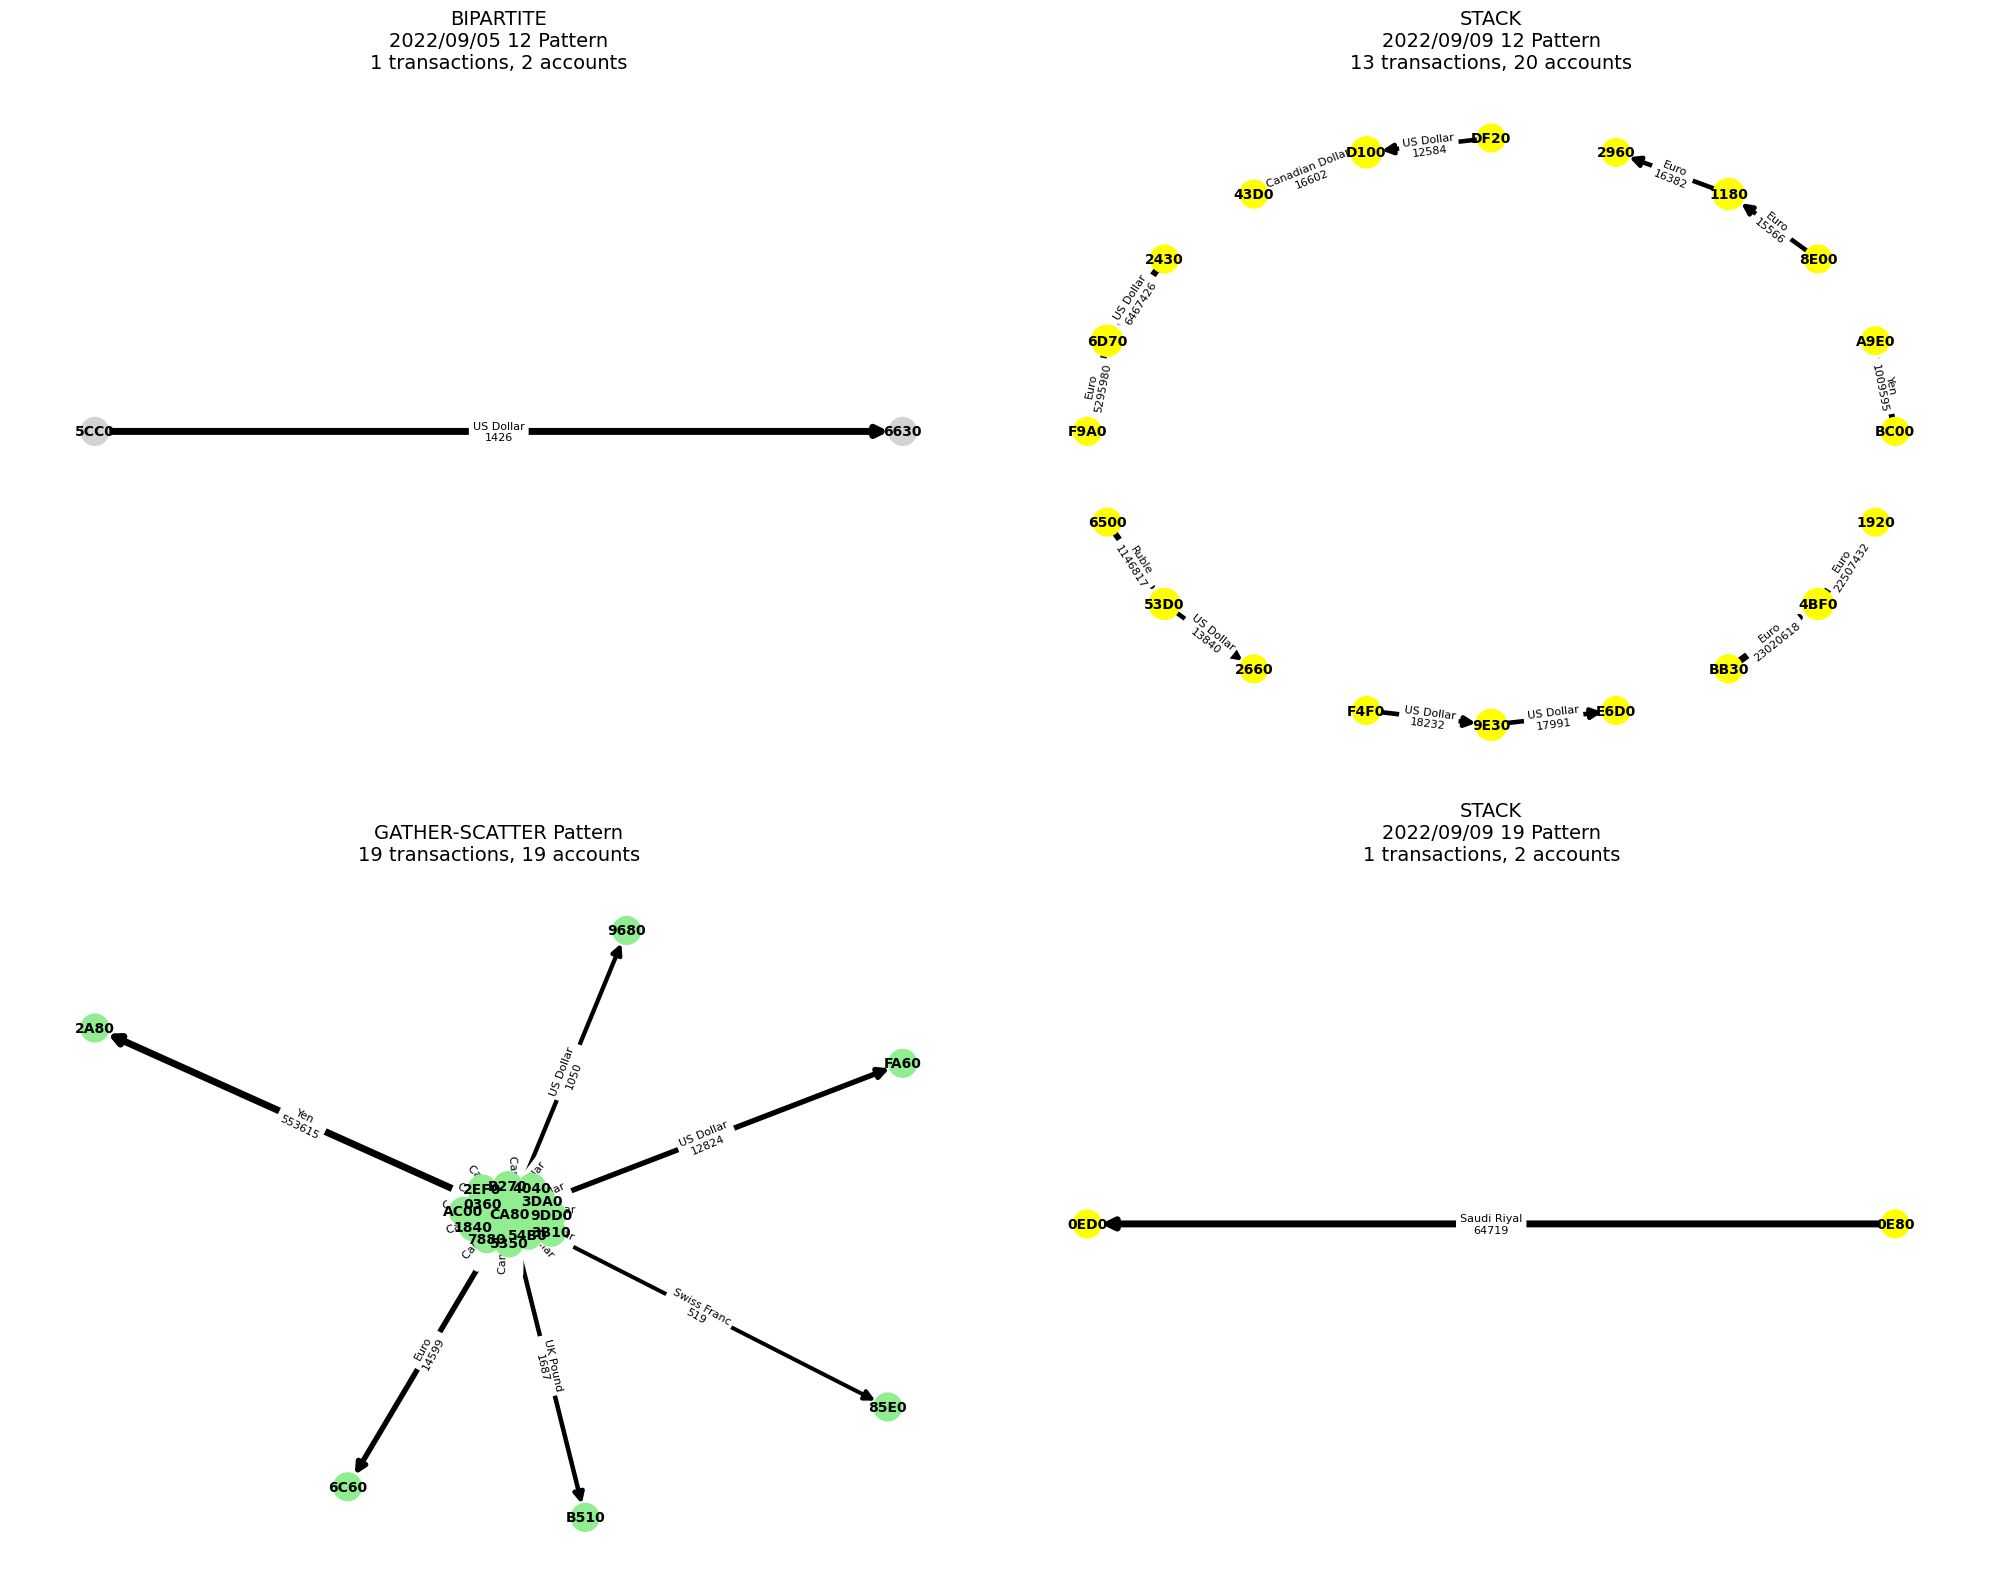

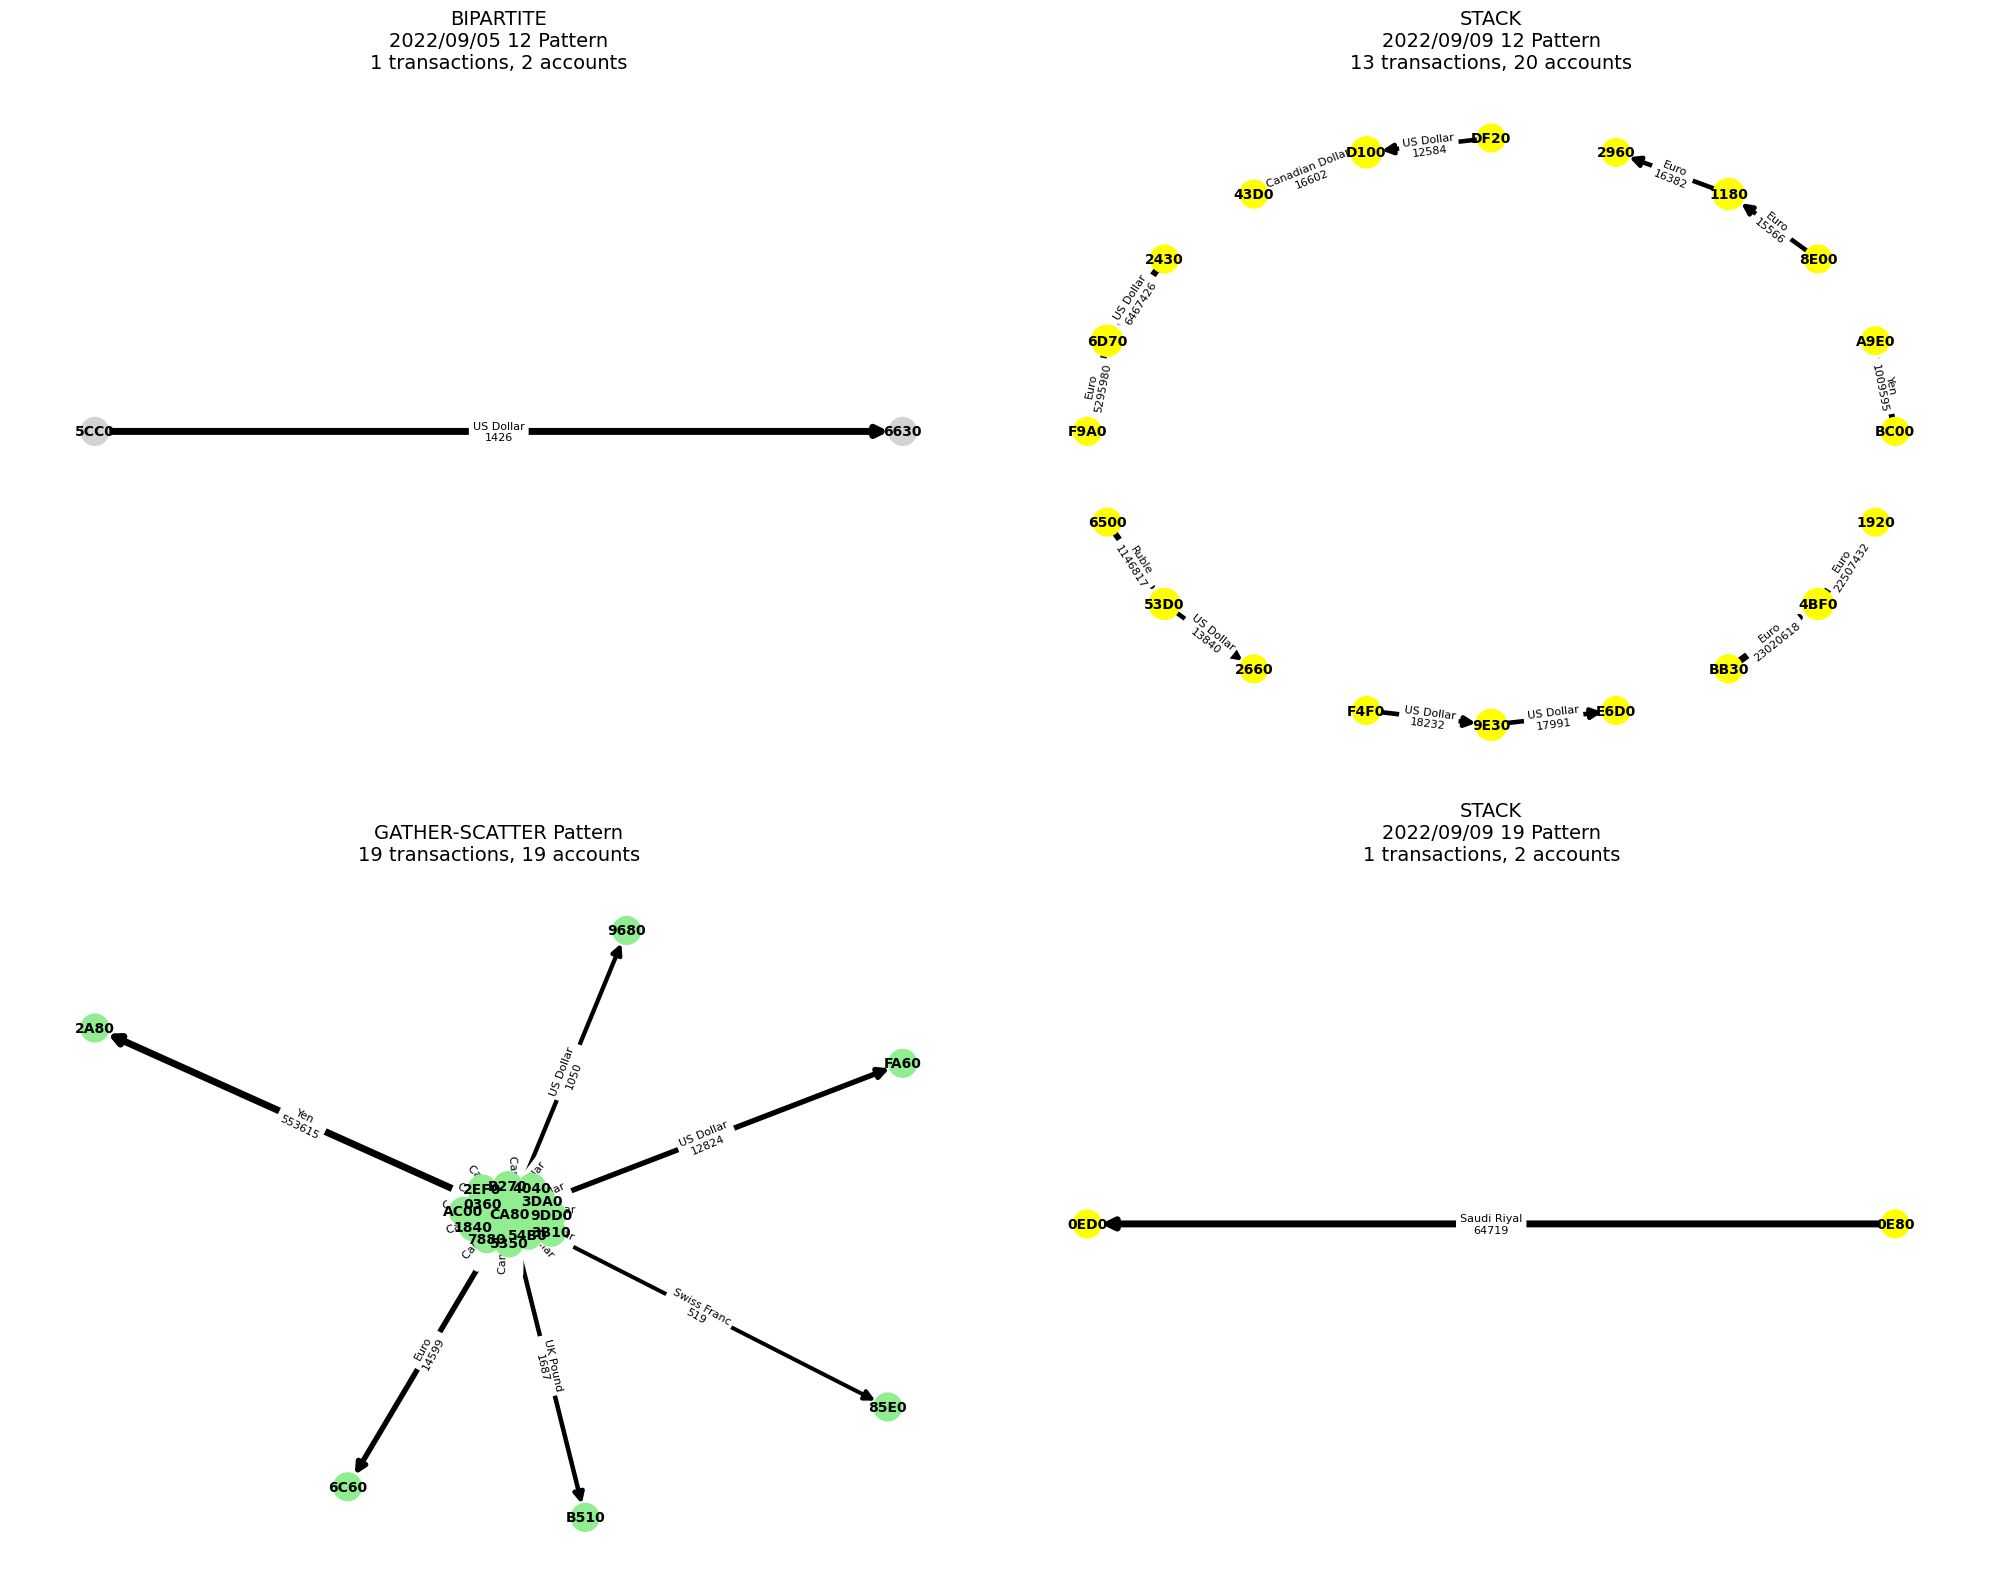

In [ ]:
parse_and_visualize_laundering_patterns("./data/IBM_AML/HI-Small_Patterns.txt", num_patterns=4)

In [ ]:
# Load the CSV file into a pandas dataframe
# only load the first 10000 rows
df = pd.read_csv("data/IBM_AML/HI-Small_Trans.csv", nrows=100000)

# Check for null values
null_values = df.isnull().sum()
print(null_values)

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64


In [ ]:
account_id = '803177AF0'

In [ ]:
def find_two_level_neighbors(df, account_id):
    # Find first level neighbors where the account is either the sender or receiver
    # Note: When pandas loads a CSV with duplicate column names, it appends suffixes
    # The columns are likely named 'Account' and 'Account.1' or similar
    first_level = df[(df['Account'] == account_id) | (df['Account.1'] == account_id)]
    
    # Collect all unique accounts that are first-level neighbors
    source_accounts = set(first_level['Account'])
    target_accounts = set(first_level['Account.1'])
    first_level_accounts = source_accounts.union(target_accounts)
    
    # Find second level neighbors
    second_level = df[(df['Account'].isin(first_level_accounts)) | (df['Account.1'].isin(first_level_accounts))]
    second_level_source = set(second_level['Account'])
    second_level_target = set(second_level['Account.1'])
    second_level_accounts = second_level_source.union(second_level_target)
    
    # Combine first and second level neighbors
    all_neighbors = first_level_accounts.union(second_level_accounts)
    subset_df = df[(df['Account'].isin(all_neighbors)) | (df['Account.1'].isin(all_neighbors))]
    
    return subset_df

In [ ]:
two_level_neighbors_df = find_two_level_neighbors(df, account_id)
print(two_level_neighbors_df)

              Timestamp  From Bank    Account  To Bank  Account.1  \
49     2022/09/01 00:14       1674  801009860     1411  80100A2C0   
50     2022/09/01 00:29       1674  801009860     1457  80100D180   
51     2022/09/01 00:11       1674  801009860        1  80100DB80   
53     2022/09/01 00:17       1674  801009860     1674  801009860   
55     2022/09/01 00:22       1457  80100D180    15916  803177AF0   
10499  2022/09/01 00:18      21575  80116A270     1674  801009860   
25227  2022/09/01 00:24      15916  803177AF0    15916  803177AF0   
34689  2022/09/01 00:04       2627  804AF6ED0     1674  801009860   

       Amount Received Receiving Currency  Amount Paid Payment Currency  \
49           424245.00          US Dollar    424245.00        US Dollar   
50             2995.00          US Dollar      2995.00        US Dollar   
51           527190.00          US Dollar    527190.00        US Dollar   
53               17.29          US Dollar        17.29        US Dollar   
55 

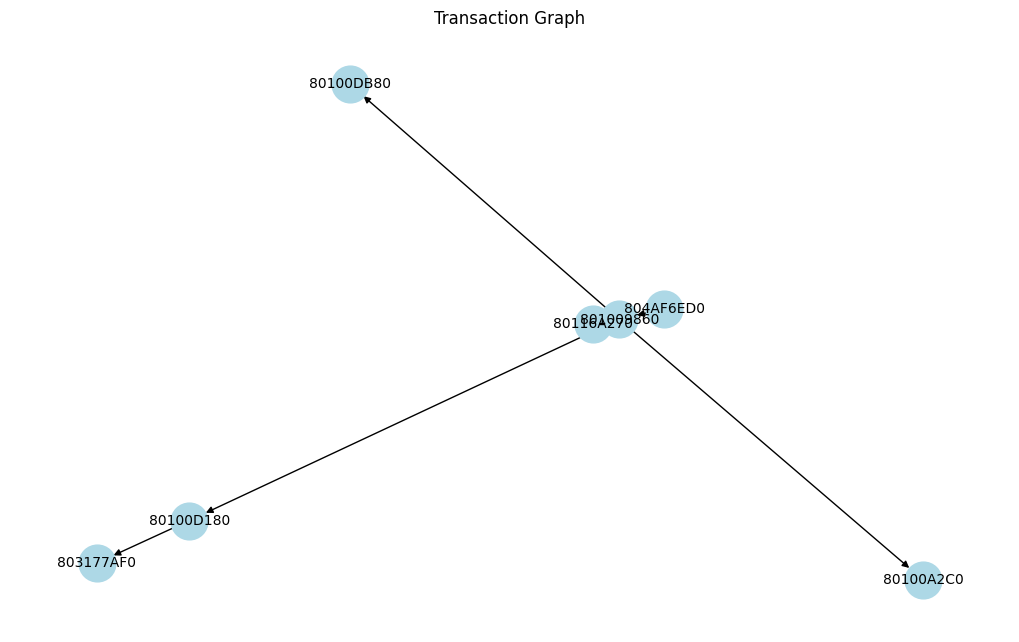

In [ ]:
def visualize_transaction_graph(df):
  """
  Visualize the transaction graph from the dataframe.
  
  Args:
    df: pandas DataFrame containing transaction data with columns:
      'Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1', 
      'Amount Received', 'Receiving Currency', 'Amount Paid', 
      'Payment Currency', 'Payment Format', 'Is Laundering'
  """
  # Create a directed graph
  G = nx.DiGraph()
  
  # Aggregate transaction amounts between accounts
  transaction_sums = df.groupby(['Account', 'Account.1'])['Amount Paid'].sum().reset_index()
  
  # Add nodes and edges to the graph
  for _, row in transaction_sums.iterrows():
    from_acct = row['Account']
    to_acct = row['Account.1']
    amount = row['Amount Paid']
    
    # Add nodes
    G.add_node(from_acct)
    G.add_node(to_acct)
    
    # Add edge with the sum of transaction amounts
    if G.has_edge(from_acct, to_acct):
      G[from_acct][to_acct]['weight'] += amount
    else:
      G.add_edge(from_acct, to_acct, weight=amount)
  
  # Draw the graph
  plt.figure(figsize=(10, 6))  # Adjusted the figure size to be smaller
  pos = nx.spring_layout(G)
  nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_color='black', arrows=True)
  plt.title("Transaction Graph")
  plt.show()

# Example usage
visualize_transaction_graph(two_level_neighbors_df)
